# 7 - Sample Data Inheritance - The Microstructure Class 

**This sixth Notebook will introduce you to**:

1. the SampleData class inheritance mechanisms
2. the Microstructure class of the pymicro package
3. the Microstructure class data model and how to browse through its content
4. the different ways that exist to create a Microstructure object
5. the basic methods to get and set the data that compose a Microstructure object 
         
<div class="alert alert-info">

**Note** 
    
Throughout this notebook, it will be assumed that the reader is familiar with the overview of the SampleData file format and data model presented in the [first notebook of this User Guide](./SampleData_Introduction.ipynb) of this User Guide.

</div>

## SampleData Inheritance

The *SampleData* class implements a generic interface between users, numeric tools, and HDF5/XDMF multimodal datasets for material science and mechanics. It allows to create empty datasets or open existing ones, and leaves entirely to the user the definition of the dataset internal content and organization.

For specific and repeated applications, that always involve the same type of datasets, it may be convenient to standardize and predefine the internal organization of the dataset. For instance, to manage the data of a serie of material samples that are studied through SEM, EBSD imaging, and numerical simulation of the imaging digital twins, you will to define for each the same Image Group to store the imaging outputs, and a Mesh or Image group at least to store the simulation output. 

For such cases, it becomes convenient to define a more specific interface, for which all the internal organization of datasets (their data mode), is already defined. For that purpose, the *SampleData* class offers the possibility to create  inherited classes with a predefined data model through two particular and simple mechanisms, that are the subject of the present section.

### Custom Data Model

The *SampleData* class defines a minimal data model for all the datasets created with the class. This data model is a collection of data item *indexnames, pathes* and *types*, in the form of two dictionaries. The keys of these two dictionaries must be identical, and define all the *indexnames* of the items in the data model. There values are:

1. `minimal_content_index_dic`: the path of each data item in the data model
2. `minimal_content_type_dic`: the type of each data item in the data model

#### The content index dictionary

Each item of this dictionary will define a data item of the model. Its key will be the *indexname* given to the data item in the dataset, and the item value must be a string giving a valid path for the data item in the dataset. For a path to be valid, the different levels of depth in it must have been declared within the dictionary.

This dictionary should hence look like this:

```python
       minimal_content_index_dic = {'item1': '/path_to_item1',
                                    'item2': '/path_to_item1/path_to_item2',
                                    'item3': '/path_to_item3',
                                     '...': '...',}
```

An item of the form `'wrongitem': '/undeclared_item/path_to_wrong_item'` would have been a non valid path.

The dictionary example just above would lead to the creation of at least 3 data items, with names `item1`, `item2` and `item3`, with items 1 and 3 being directly attached to the dataset *Root Group*, and the item 2 being a children of item 1. 

#### The content type dictionary

The second dictionary that has to be declared must have the same keys as the `minimal_content_index_dic`. Its values must be valid *SampleData* data item types. This dictionary will determine the type of data item that will be automatically created at the dataset creation, by the subclass. 

Possible values and associated data types are (see previous tutorials for description of these data types):

* 'Group': creates a HDF5 group data item
* '2DImage', '3DImage', or 'Image': creates an empty Image group
* '2DMesh', '3DMesh', 'Mesh': creates an empty Mesh group
* 'data_array': creates an empty Data Array
* 'field_array': creates an empty Field Array (its path must be a children of a an Image or Mesh group)
* 'string_array': creates an empty String Array 
* a `numpy.dtype` or a `tables.IsDescription` class ([see here](https://www.pytables.org/usersguide/libref/declarative_classes.html#the-isdescription-class) and [tutorial 3](./2_SampleData_basic_data_items.ipynb)):

This dictionary should look like this (assuming that it corresponds to the content dictionary of the subsection above):

```python
       minimal_content_index_dic = {'item1': '3DMesh',
                                    'item2': 'field_array',
                                    'item3': 'data_array',
                                     '...': '...',}
```

In this case, the first item would be created as a *Mesh Group*, the second will be created as a field data item stored in this mesh, and the last as a data array attached to the *Root Group*.

*****
These two dictionaries are returned by the `minimal_data_model` method of the `SampleData` class. They are used during the dataset object initialization, to create the prescribed data model, and populate it with empty objects, with the right names and organization. This allows to prepend a set of names and pathes that form a particular data model that all objects created by the class should have.

It is labelled as a **minimal data model**, as it only prescribes the data items and organization that will be present in each dataset of the subclass. The user is free to enrich the datasets created with this class with any additional data item that he would want to add.

In the `SampleData` code, they are returned empty, so that no actual data model is created within a new `SampleData` dataset. This method is actually designed to create subclasses of SampleData associated to a specific data model. To achieve this, you have to:

1. Create a new class, inherited from SampleData
2. Override the `minimal_data_model` method and write your data model in the two dictionaries returned by the class 

You will then get a class derived from *SampleData* (hence with all its methods and features), that creates datasets with this prescribed data model. You will see an example of it in the next section dedicated to the Microstructure class, which is designed this way.

### Custom initialization

The other mechanisms that is important to design subclasses of *SampleData*, is the specification of all initialization commands that must be run each time the dataset files are closed and opened again (this happens for instance when repacking the dataset, or calling the `pause_for_visualization` method). These operations can include, for instance, the definition of class attributes that points toward a specific node in the dataset, the loading of data from the dataset files in some class attributes, some sanity checks on the data etc.....

All these operations must be implemented in the `_after_file_open` method of the subclass. Again, the `Microstructure` class described in the next section will provide an example.

## The Microstructure Class

The `Microstructure` class has been designed to handle multimodal datasets representing polycrystalline material samples. These materials have a specific microstructure composed of crystalline grains, that are characterized by a specific geometry and a crystalline orientation. The microstructure of polycrystalline materials strongly determines their physical and mechanical properties, and is thus extensively studied by material scientists.

The `Microstructure` class offers methods to easily manipulate multiomdal 4D data of granular material samples, in particular regarding geometrical and crystallographic aspects of data management and processing. As this type of data is a particular case of the  of datasets for which the `SampleData` class has been designed, the `Microstructure` has been derived from the `SampleData` class.

### A SampleData children class

Indeend, the `Microstructure` class is a subclass of the `SampleData` class:
```python
class Microstructure(SampleData):
```

As a children of `SampleData`, it inherits all of its features: a *Microstructure* object is associated with a HDF5/XDMF file pair, and allows to create/get/remove/compress all types of data items handeled by the `SampleData` class, presented in the previous tutorials. As a children of `SampleData`, the `Microstructure` class benefits of the two mechanisms presented in the first section of this tutorial. We will see now how they are implemented for this class.

### The minimal data model

This subsection will present the `Microstructure` class data model, and will also serve as a demonstrator of the data model mechanism described in the first section of this tutorial.

The code of the `minimal_data_model` method of the *Microstructure* class contains the following declaration of the data model dictionaries:

```python
        minimal_content_index_dic = {'Image_data': '/CellData',
                                     'grain_map': '/CellData/grain_map',
                                     'phase_map': '/CellData/phase_map',
                                     'mask': '/CellData/mask',
                                     'Mesh_data': '/MeshData',
                                     'Grain_data': '/GrainData',
                                     'GrainDataTable': '/GrainData/GrainDataTable',
                                     'Phase_data': '/PhaseData'}
        minimal_content_type_dic = {'Image_data': '3DImage',
                                    'grain_map': 'field_array',
                                    'phase_map': 'field_array',
                                    'mask': 'field_array',
                                    'Mesh_data': 'Mesh',
                                    'Grain_data': 'Group',
                                    'GrainDataTable': GrainData,
                                    'Phase_data': 'Group'}
```

You can see that this data model contains a `GrainData` data item type. This is a `tables.IsDescription` object, inducing hence the creation of a *Structured Array* data item. The definition of this description in the `Microstructure` class code will be provided further in this tutorial, in the subsection dedicated to the *Grain Data Table* data item of the class.

As you can see, the data model contains one Image Group, with three fields declared, one Mesh Group, two Groups, one containing a *Structured Array* data item. It will be detailed in the next section of this tutorial.

### The after file open operations 

The `_after_file_open` method of the `Microstructure` class is very simple, it contains juste one line of code:
```python
    def _after_file_open(self):
        """Initialization code to run after opening a Sample Data file."""
        self.grains = self.get_node('GrainDataTable')
        return
```

This method creates a class attribute `grains` that is associated with the *Structured Array* node `GrainDataTable`.  Therefore, this attribute is an alias for the *Pytable* *Node* object associated to this array (see [here](https://www.pytables.org/usersguide/tutorials.html) how to handle these objects).

This `grains` attribute is used by many of the class methods, and hence must always be properly associated to the *GrainDataTable*. To ensure that it is the case, it is initialized in the `_after_file_open` method. Hence, this attribute is initialized at dataset opening, but also after in the methods that close and re-open the dataset (like `pause_for_visualization` or `repack_h5file`.

## Microstructure Data Model & Getting Microstructure data

### What data defines a Microstructure ?

To define the microstructure and geometry of a polycrystalline sample, the following information are needed:

* the description of the geometry of the sample
* inside the sample, the description of the crystalline phases that compose the sample
* within each phase, the description of the grains that compose the phase

**To easily identify these elements, in a `Microstructure` dataset, each phase and grain in the microstructure has a identification number.** These numbers are used to gather phasewise or grainwise data in data arrays, but is used as well in fields to describe the geometry of these phases/grains. These features are detailed in the following. 

We will now review the various elements of the `Microstructure` class data model. To illustrate them, we will use a dataset from the example data base of the pymicro package.

### Opening a Microstructure file

Opening an already existing microstructure dataset is done exactly like opening a `SampleData` dataset. We will look at a material science dataset that is part of the *Pymicro* example datasets, that is already used in the [previous tutorial](5_SampleData_data_compression.ipynb) on data compression.

In [2]:
from config import PYMICRO_EXAMPLES_DATA_DIR # import file directory path
import os
dataset_file = os.path.join(PYMICRO_EXAMPLES_DATA_DIR, 'example_microstructure') # test dataset file path
tar_file = os.path.join(PYMICRO_EXAMPLES_DATA_DIR, 'example_microstructure.tar.gz') # dataset archive path

This file is zipped in the package to reduce its size. We will have to unzip it to use it and learn how to reduce its size with the *SampleData* methods. If you are just reading the documentation and not executing it, you may just skip this cell and the next one.

In [2]:
# Save current directory
cwd = os.getcwd()
# move to example data directory
os.chdir(PYMICRO_EXAMPLES_DATA_DIR)
# unarchive the dataset
os.system(f'tar -xvf {tar_file}')
# get back to UserGuide directory
os.chdir(cwd)

Let us now open the dataset, using the `Microstructure` class constructor this time:

In [3]:
# import SampleData class
from pymicro.crystal.microstructure import Microstructure 
# import Numpy
import numpy as np

In [4]:
# Open Microstructure dataset
micro = Microstructure(filename=dataset_file)

The dataset is now open, we can now look at its content:

In [11]:
print(micro)

Microstructure
* name: Ti_grade2_ET7_3_crop100
* lattice: Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0

Dataset Content Index :
------------------------:
index printed with max depth `3` and under local root `/`

	 Name : GrainDataTable                            H5_Path : /GrainData/GrainDataTable 	
	 Name : Grain_data                                H5_Path : /GrainData 	
	 Name : Image_data                                H5_Path : /CellData 	
	        Image_data aliases --> `CellData`
	 Name : Image_data_Amitex_stress_1                H5_Path : /CellData/Amitex_output_fields/Amitex_stress_1 	
	 Name : Image_data_grain_map                      H5_Path : /CellData/grain_map 	
	 Name : Image_data_grain_map_raw                  H5_Path : /CellData/grain_map_raw 	
	 Name : Image_data_mask                           H5_Path : /CellData/mask 	
	 Name : Image_data_uncertainty_map                H5_Path : /CellData/uncertainty_map 	
	 Name : Mesh_da

We can also print the description attribute of the dataset to read information written by its creators:

In [25]:
print(micro.get_description())

Dataset representing a subvolume of a grade 2 Titanium sample.
  * Obtained by cropping a full DCT microstructure of the sample to get a 100x100x100 voxels sub image
  * Contains a mesh of the polycrystalline microstructure, conformal with the grains geometry
  * Contains FFT simulation results
  * Contains DCT imaging outputs



As you can see, this dataset is a digital twin of a real polycristalline microstructure of a grade 2 Titanium sample, gathering both experimental and numerical data obtained through Diffraction Contrast Tomography imaging, and FFT-based mechanical simulation. 

This dataset will serve as an illustration of the `Microstructure` class data model. In the dataset content printed above, we indeed recognize the 4 groups defined by the `minimal_data_model`. They all contain essential data to represent the microstructure, and are presented in details in the next subsections. 

### Phases

Obviously, the first information that must be provided when describing a polycrystalline material sample, is its composition. Polycrystalline samples may be composed of multiple phases, having all distinct crystallographic and physical properties. The `PhaseData` group in the `Microstructure` data model is designed to store this essential information on the various material phases composing the sample, and their properties. 

We can see in the dataset content above that this *Group* only contains another group `phase_01`. Their content is:

In [26]:
micro.print_node_info('PhaseData')
micro.print_node_info('phase_01')


 GROUP PhaseData
 -- Parent Group : /
 -- Group attributes : 
	 * group_type : Group
 -- Childrens : phase_01, 
----------------


 GROUP phase_01
 -- Parent Group : PhaseData
 -- Group attributes : 
	 * description : Polycrystalline alpha grade 2 Titanium phase
	 * elastic_constants : [162000.0, 92000.0, 69000.0, 180000.0, 46700.0]
	 * elastic_constants_unit : MPa
	 * formula : Ti
	 * group_type : Group
	 * lattice_parameters : [1.0, 1.0]
	 * lattice_parameters_unit : nm
	 * name : Ti grade 2
	 * phase_id : 1
	 * symmetry : hexagonal
 -- Childrens : 
----------------



As you may observe, these groups only contain data in the form of attributes, *i.e.* metadata, on the crystalline phase that compose the dataset. **The `PhaseData` group has as many children groups as there are phases in the dataset**. Each one of these groups has a predefined name, following the pattern `phase_+ phase_number`. They provide the name, number, and crystallographic (symmetry, lattice parameters), chemical (formula) and physical information (elasticity constants) of each phase.

         
<div class="alert alert-warning">

**Warning** 
    
Working with multiple phases in `Microstructure` datasets is still a feature under development, not yet stable. It is possible to have mutliple phase groups within a dataset, but some class methods working with Phases may not yet be compatible with multiple phase datasets. 

</div>

#### Getting Phase objects from a dataset

The medata content of a `phase_XX` *Group* can be retrieved as a *Pymicro* Phase object, which is a container object, with the `get_phase` method:

In [5]:
phase_01 = micro.get_phase(phase_id=1)
print(phase_01)

Phase 1 (Ti grade 2) 
	-- Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0
	-- elastic constants: [162000.0, 92000.0, 69000.0, 180000.0, 46700.0]


### The CellData Group

#### Group aim and content

We will move now to the description of the `CellData` group. As you can see, it is an *Image Group* (3D image in the case of this example file). **The `CellData` group is aimed at storing descriptions of the polycristalline microstructure of the sample, in the form of images.** They may describe the geometry and orientation of the grains, the presence of damage or the micromechanical state of the sample. 

These images can be 2D or 3D, and be:

* outputs of real imaging experiments (DCT, CT, EBSD ...)
* digitally generated microstructure images (Voronoi tesselations, outputs from softwares like Neper, DREAM3D ...)
* outputs of numerical simulations techniques that provide images (such as FFT-based solvers)

This group is a classical *Image Group*, with the usual set of attributes (see [dedicated tutorial](./3_SampleData_Image_groups.ipynb)):

In [10]:
micro.print_node_info('CellData')


 GROUP CellData
 -- Parent Group : /
 -- Group attributes : 
	 * active_grain_map : grain_map
	 * description :  
	 * dimension : [100 100 100]
	 * empty : False
	 * group_type : 3DImage
	 * nodes_dimension : [101 101 101]
	 * nodes_dimension_xdmf : [101 101 101]
	 * origin : [0. 0. 0.]
	 * spacing : [0.00122 0.00122 0.00122]
	 * xdmf_gridname : CellData
 -- Childrens : Amitex_output_fields, grain_map, grain_map_raw, mask, phase_map, uncertainty_map, Field_index, 
----------------



#### Group minimal content

The `minimal_data_model` of the class contains three fields data items that are attached to the *CellData* group. **These scalar fields of integers allow to completely describe the geometry and microstructure of the polycrystalline material sample associated to the `Microstructure` dataset.** They are:

* `mask`: a field describing the geometry of the sample. It has a 1 value inside the sample, and a 0 value outside the sample (typically, segmented X-ray Contrast Tomography outputs can be used as Microstructure mask). 
* `phase_map`: a field indicating for each pixel/voxel the ID of the phase in which it is located. In areas of the Image that are not part of the material sample, the *grain_map* field takes a zero or negative value.
* `grain_map`: a field indicating for each pixel/voxel the ID of the grain in which it is located. In areas of the Image that are not part of the material sample, the *grain_map* field takes a zero or negative value.

You can retrieve the value of these fields as shown in the previous tutorials (`get_field`, attribute or dict like access). You can also use the `Microstructure` class dedicated methods, that ensure to return arrays of dimension 3 (with a 1 sized 3 dimension when getting 2D images fields), used just below:

In [20]:
mask = micro.get_mask()
phase_map = micro.get_phase_map()
grain_map = micro.get_grain_map()

print(f'List of values in the mask:\n {np.unique(mask)}\n')
print(f'List of values in the phase map:\n {np.unique(phase_map)}\n')
print(f'List of values in the grain map:\n {np.unique(grain_map)}\n')

print(f'Number of grains in the grain map: {len(np.unique(grain_map))}')

List of values in the mask:
 [1]

List of values in the phase map:
 [None]

List of values in the grain map:
 [   2    3   34   43   46   73   98  107  137  164  196  223  245  252
  310  327  345  384  433  435  437  452  484  485  488  503  540  649
  672  684  692  744  783  802  824  849  851  859  870  903  953  998
 1019 1025 1054 1059 1061 1062 1096 1124 1163 1210 1251 1270 1306 1335
 1346 1384 1392 1407 1438 1494 1521 1529 1534 1560 1564 1617 1634 1642
 1650 1686 1772 1855 1893 1897 1900 1905 2031 2059 2225 2307 2335 2508
 2558 2726 2770 2852 2895 2929 2934 3025 3048 3053 3074 3101 3154 3183
 3319 3448 3575 3587 3604 3613 3620 3643 3724 3812 3827 3918 3960]

Number of grains in the grain map: 111


As you can see, the *phase map* is not defined here, which is not a problem when the sample only has one crystalline phase (which is the case here). The mask also contains only 1 values, which means that the dataset represents a full cube of the sample microstructure. The grain map contains 111 grain IDs values. 

#### The active grain map class attribute

It may be relevant, for some datasets, to store several fields for the same information. For instance, when reconstructing a microstructure from an imaging experiment, the microstructure in the reconstruction process raw output may be incomplete, and require some image processing. In that case, storing both versions of the array (raw reconstruction output and image after processing) is relevant. 

In the specific case of the `grain_map` field, if you have several arrays for this information in your dataset, you may use the `active_grain_map` class attribute to specify which one is to be considered as the sample main grain map by setting the `Microstructure.active_grain_map` attribute to a name of this field data item. This implies that the `get_grain_map` method will return specifically this field, and that all `Microstructure` methods working with the sample grain map will use this field as well.

Our example dataset has two version of the grain map information: the `grain_map` and `grain_map_raw` fields. They represent the processed and raw version of the DCT reconstruction algorithm output data. We will use them to illustrate the role of the `active_grain_map` attribute. 

You can set its value with the `set_active_grain_map` method: 

In [29]:
# print active grain map
print(f'The active grain map is {micro.active_grain_map}')

# change active grain map
micro.set_active_grain_map('grain_map_raw')
print(f'The active grain map is {micro.active_grain_map}')

The active grain map is grain_map
The active grain map is grain_map_raw


We can now chekc the return of `get_grain_map`:

In [30]:
# get both grain maps arrays
grain_map = micro['grain_map']
grain_map_raw = micro['grain_map_raw']

# check class method return grain map
print(f'Is the active grain map equal to "grain_map" array ? {np.all(grain_map == micro.get_grain_map())}')
print(f'Is the active grain map equal to "grain_map_raw" array ? {np.all(grain_map_raw == micro.get_grain_map())}\n')

# let us change again the grain map and redo the test
micro.set_active_grain_map('grain_map')
print(f'Is the active grain map equal to "grain_map" array ? {np.all(grain_map == micro.get_grain_map())}')
print(f'Is the active grain map equal to "grain_map_raw" array ? {np.all(grain_map_raw == micro.get_grain_map())}')


Is the active grain map equal to "grain_map" array ? False
Is the active grain map equal to "grain_map_raw" array ? True

Is the active grain map equal to "grain_map" array ? True
Is the active grain map equal to "grain_map_raw" array ? False


<div class="alert alert-info">

**Note** 
    
Note that the same mechanism will be implemented soon for the phase map field.


</div>

#### Visualize sample microstructure image: View Slice method

These three arrays, as *Field data items* of the *CellData* group can be visualized by opening the HDF5 dataset file with the Paraview software, as the `Microstructure` class inherits this feature from `SampleData`. In addition, the `Microstructure` class provides a visualization method to plot a slice of the microstructure (hence the whole image if it is a 2D microstructure) using the `grain_map` and `mask` arrays.

This method is the `view_slice_method`. It has many input arguments, but can be called without any one. Let us see which output it produces in this case:

using slice value 50


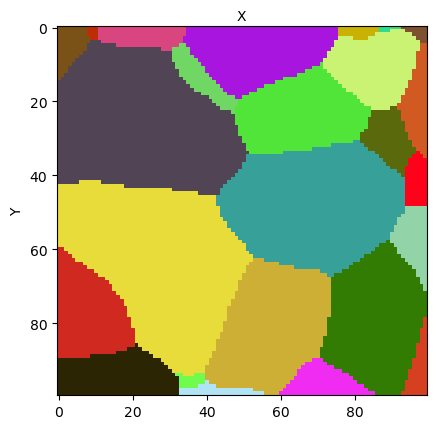

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [31]:
micro.view_slice()

When no argument is provided, the method plots the middle (X,Y)-wise slice of the sample grain map, with a random color map for the grain ids, and shows the mask on the foreground in transparency mode. Here the mask cannot be actually seen as it is uniform on the slice. 

Let us plot a slice of an other example dataset that allows to see the mask: 

using slice value 0


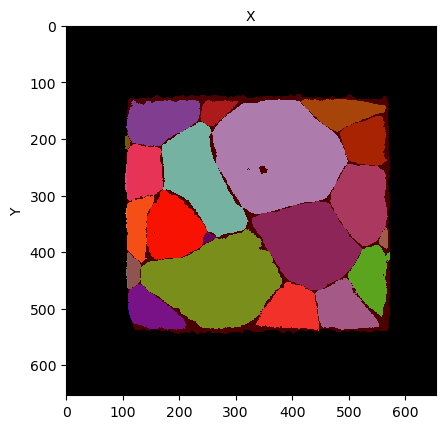

In [35]:
micro2 = Microstructure(filename=os.path.join(PYMICRO_EXAMPLES_DATA_DIR,'t5_dct_slice_data.h5'))
micro2.view_slice()
del micro2

The mask shows two regions, a black region representing the outside of the sample, and a red region, representing the sample geometry. The grain map appear below this transparent mask color layer.

The `view_slice` method has many optional arguments. The most important are:

* `slice`: this argument allows you to choose the index of the slice that is plotted. The default value is the middle slice.
* `color`: allows you to chose the color map used to plot the grains. `random` is the default value, alternatives are `grain_ids`, `ipf` (inverse pole figure coloring) and `schmid` (plot intensity of grain maximal schmid factor for the load direction specified by the `axis` argument, and for the slip system object provided in the `slip_system` argument)
* `show_mask`: set to *False* if you do not want to plot the mask 
* `show_grain_ids`: set to *True* to annotate the grains with their ID number 
* `show_slip_traces`: set to *True* to annotate the grains with the trace of a slip plane (provided as a slip system object to the `hkl_planes` argument)
* `display`: is set to *False*, the image is not plotted. The matplotlib figure and axis created are returned anyway by the method.

You will find below two examples. If you are reading through the Notebook version of the documentation, you may try to change the value of these arguments to experiment the various possibilities offered by the `view_slice` method.

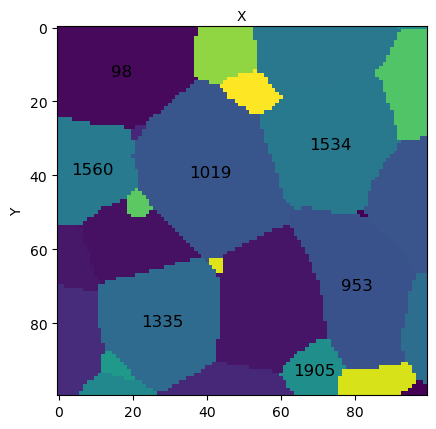

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [5]:
micro.view_slice(slice=15, color='grain_ids', show_grain_ids=True, highlight_ids=[98,953,1019,1335,1534,1560,1905])

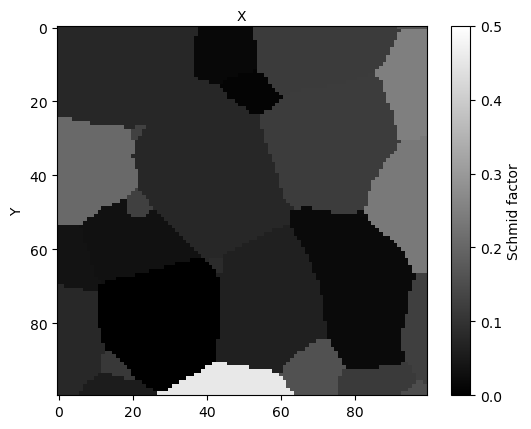

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [7]:
# get one basal slip system to compute its schmid factors and plot them on the slice
from pymicro.crystal.lattice import SlipSystem
lattice = micro.get_phase().get_lattice()
slip_system = lattice.get_slip_systems('basal')[1]

# plot slice with schmid factor colormap
micro.view_slice(slice=15, color='schmid', slip_system=slip_system)

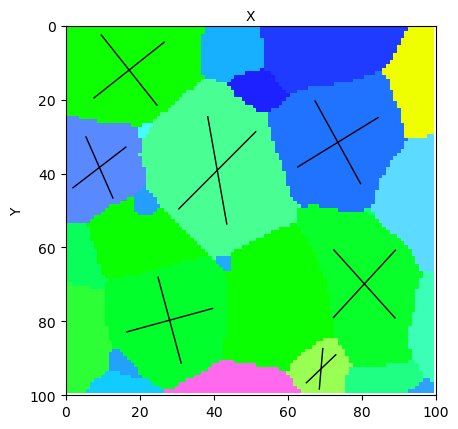

[HKL Plane
 Miller indices:
 h : 0
 k : 0
 l : 1
 plane normal : [0. 0. 1.]
 crystal lattice : Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0, HKL Plane
 Miller indices:
 h : -1
 k : 0
 l : 0
 plane normal : [-8.66025404e-01 -5.00000000e-01  1.06057524e-16]
 crystal lattice : Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0]


In [18]:
# Get two slip planes (basal and one prismatic) to plot slip plane traces on the selected grains, 
# coloured with inverse pole figure color map
plane_list = []

slip_system = lattice.get_slip_systems('basal')[0]
plane_list.append(slip_system.get_slip_plane())
slip_system = lattice.get_slip_systems('prism')[1]
plane_list.append(slip_system.get_slip_plane())

micro.view_slice(slice=15, color='ipf', slip_system=slip_system, show_slip_traces=True, hkl_planes=plane_list,
                 highlight_ids=[98,953,1019,1335,1534,1560,1905])
print(plane_list)

### The GrainData Group

#### Group aim and content

We will move now to the description of the `GrainData` group. As you can see, it is a classical HDF5 *Group*. **The `GrainData` group is aimed at storing statistical data describing the sample grains.** In the data model as well as in the example dataset, this Group has contains only one data item, the **GrainDataTable**.

The **GrainDataTable** is a structured array that contains the statistical data describing the grains. Its description in the *Pymicro* code is:

```python
class GrainData(tables.IsDescription):
    """
       Description class specifying structured storage of grain data in
       Microstructure Class, in HDF5 node /GrainData/GrainDataTable
    """
    # grain identity number
    idnumber = tables.Int32Col()  # Signed 32-bit integer
    # grain volume
    volume = tables.Float32Col()  # float
    # grain center of mass coordinates
    center = tables.Float32Col(shape=(3,))  # float  (double-precision)
    # Rodrigues vector defining grain orientation
    orientation = tables.Float32Col(shape=(3,))  # float  (double-precision)
    # Grain Bounding box
    bounding_box = tables.Int32Col(shape=(3, 2))  # Signed 64-bit integer
```

As you can see, each row contains:

* the identity number of the grain
* two columns describing the grain geometry: grain volume, position of grain center of mass
* the orientation of the grain provided as a **Rodrigues** vector
* the indices of the grain bounding box in the `CellData` image field arrays

#### Getting information on grains from Grain Data Table

Like for the *CellData* group items, you can retrieve the *GrainDataTable* columns value as shown in the previous tutorials (`get_node`, attribute or dict like access). You can also use the `Microstructure` class dedicated methods, used just below:

In [26]:
# retrieve table as numpy structured array with dictionary like access
GrainDataTable = micro['GrainDataTable']

# get table columns from class methods and compare to numpy array
grain_ids = micro.get_grain_ids()
print(f'grain ids equal ? {np.all(grain_ids == GrainDataTable["idnumber"])}')
grain_centers = micro.get_grain_centers()
print(f'grain centers equal ? {np.all(grain_centers == GrainDataTable["center"])}')
grain_volumes = micro.get_grain_volumes()
print(f'grain volumes equal ? {np.all(grain_volumes == GrainDataTable["volume"])}')
grain_bboxes = micro.get_grain_bounding_boxes()
print(f'grain bounding boxes equal ? {np.all(grain_bboxes == GrainDataTable["bounding_box"])}')
grain_rodrigues = micro.get_grain_rodrigues()
print(f'grain orientations equal ? {np.all(grain_rodrigues == GrainDataTable["orientation"])}')

grain ids equal ? True
grain centers equal ? True
grain volumes equal ? True
grain bounding boxes equal ? True
grain orientations equal ? True


Other methods to get specific grain data are also available in the class interface:

In [31]:
centers = micro.get_grain_positions()
print(f'The position of the 10 first grain centers of mass are:\n {centers[:10]}\n')

volume_fractions = micro.get_grain_volume_fractions()
print(f'The 10 first grain volume fractions are:\n {volume_fractions[:10]}\n')

volume_fr = micro.get_grain_volume_fraction(1335)
print(f'Volume fraction of grain 1335 is {volume_fr*100}%')

The position of the 10 first grain centers of mass are:
 [[ 0.05650836  0.05867881 -0.04994912]
 [ 0.02869466  0.00739364 -0.05561062]
 [-0.03373204  0.02536774  0.04139666]
 [-0.00488     0.060146    0.060268  ]
 [-0.00521397 -0.01333876  0.05817775]
 [ 0.00187614 -0.05681766  0.05338208]
 [-0.03986695 -0.04861747 -0.03584476]
 [ 0.00257532 -0.0298424   0.03544907]
 [ 0.05424954 -0.04179282  0.03134331]
 [-0.0300348   0.01446837 -0.00940701]]

The 10 first grain volume fractions are:
 [6.1100005e-04 1.2865001e-02 6.3486010e-02 2.0000001e-05 3.6640004e-03
 3.7020005e-03 2.9416002e-02 8.2998008e-02 9.9510010e-03 7.1037009e-02]

Volume fraction of grain 1335 is 1.938900351524353%


#### Getting grain objects

*Pymicro* also has *Grain* objects that are specific containers equivalent to a row of the dataset *GrainDataTable*. You can get them with the following methods: 

In [50]:
# get the grain object of a specific grain
grain = micro.get_grain(1335)
print(f'Grain 1335 grain object:\n {grain}')

Schmid = grain.schmid_factor(lattice.get_slip_systems('basal')[0]) 
print(f'Schmid factor of grain {grain.id} for first basal slip system is {Schmid}')

Grain 1335 grain object:
 Grain
 * id = 1335
 * Crystal Orientation 
-------------------
orientation matrix = 
 [[ 0.86979023 -0.23651806 -0.43304061]
 [-0.41716777  0.11619364 -0.90137121]
 [ 0.26350713  0.96465445  0.00239638]]
Euler angles (degrees) = ( 164.722,  89.863, 205.661)
Rodrigues vector = [-0.9384652   0.35030912  0.0908527 ]
Quaternion = [ 0.70504969  0.66166461 -0.24698534  0.06405567]
 * center [-0.0273755   0.0372526  -0.04865015]
 * has vtk mesh ? False

Schmid factor of grain 1335 for first basal slip system is 0.001037729482748718


In [51]:
# get a list of all grain objects in the microstructure
grains_list = micro.get_all_grains()
print(f'First 2 grain objects of the microstructure:\n {grains_list[:2]}')

First 2 grain objects of the microstructure:
 [Grain
 * id = 2
 * Crystal Orientation 
-------------------
orientation matrix = 
 [[ 0.3111274   0.59834852  0.73836226]
 [ 0.11859268  0.74640592 -0.65483891]
 [-0.94293985  0.2913027   0.16126758]]
Euler angles (degrees) = ( 252.832,  80.720, 131.569)
Rodrigues vector = [-0.42642024 -0.75775258  0.21622302]
Quaternion = [ 0.744782    0.31759011  0.56436047 -0.16103901]
 * center [ 0.05650836  0.05867881 -0.04994912]
 * has vtk mesh ? False
, Grain
 * id = 3
 * Crystal Orientation 
-------------------
orientation matrix = 
 [[ 0.55125435 -0.54673326 -0.63023916]
 [-0.38553982  0.50297086 -0.77354986]
 [ 0.73991736  0.66940502  0.06647743]]
Euler angles (degrees) = ( 132.136,  86.188, 219.171)
Rodrigues vector = [-0.68041358  0.64608611 -0.07600945]
Quaternion = [ 0.72813162  0.49543064 -0.47043572  0.05534488]
 * center [ 0.02869466  0.00739364 -0.05561062]
 * has vtk mesh ? False
]


#### The grains class attribute

The `Microstructure.grains` attribute is, as mentioned earlier, an alias for the *Pytables* node associated to the *GrainDataTable* data item. As such, it allows to manipulate and interact with the *GrainDataTable* content directly in the dataset. 

You can use this attribute to access grain data just like you would manipulate a *Numpy* structured array: 

In [43]:
print(micro.grains[0]['center'],'\n')
print(micro.grains[4:10]['orientation'])

[ 0.05650836  0.05867881 -0.04994912] 

[[ 0.5890785   0.6887171   0.0980203 ]
 [-0.76733357  0.32743722  0.07196987]
 [-0.7142779  -0.61377376  0.19212927]
 [ 0.51318526  0.6922173   0.09951874]
 [ 0.77879316 -0.64933205 -0.16091348]
 [ 0.21065354 -0.9373515   0.23172894]]


This attribute can also be iterated:

In [47]:
# iterate through grains with ID number below 100
for g in micro.grains:
    if g["idnumber"] > 100:
        break
    print(f'Grain {g["idnumber"]} center of mass is located at {g["center"]}')

Grain 2 center of mass is located at [ 0.05650836  0.05867881 -0.04994912]
Grain 3 center of mass is located at [ 0.02869466  0.00739364 -0.05561062]
Grain 34 center of mass is located at [-0.03373204  0.02536774  0.04139666]
Grain 43 center of mass is located at [-0.00488   0.060146  0.060268]
Grain 46 center of mass is located at [-0.00521397 -0.01333876  0.05817775]
Grain 73 center of mass is located at [ 0.00187614 -0.05681766  0.05338208]
Grain 98 center of mass is located at [-0.03986695 -0.04861747 -0.03584476]


### The MeshData Group 

**The `MeshData` group is aimed at storing descriptions of the polycristalline microstructure of the sample, in the form of a mesh.** In the present dataset, this group is used as a container group for a *Mesh Group*, `grains_mesh`. Mesh support has not yet been developped for *Pymicro* `Microstructure` class, and hence the data model of this group is for now empty.  

### Additional data items

As you can see above, the example dataset also contains data items that are not defined in the data model of the `Microstructure` class (the `Amitex_Results` *Group*, several fields of the `CellData` image...). Obviously, as a *SampleData* children class, with *Microstructure* class, you may add any additional data item to your datasets, as you would with *SampleData* datasets.

This concludes the presentation of the `Microstructure` class data model and data access.

## Creating and setting Microstructures

Now that the class data model has been presented, we will now introduce how to create and fill *Microstructure* objects.

There are three ways to create a *Microstructure* dataset:

1. Creating an empty microstructure dataset 
2. Copying an existing microstructure dataset, or a croped version of this microstructure
3. Create a Microstructure object from a compatible data file contaning microstructure data. These files can be outputs of imaging techniques (reconstruction of DCT or EBSD scans for instance) or microstructure generation tools (such as Neper)

The third point will be the subject of detailed and specific Notebook. The first will be presented further in the tutorial to build a full microstructure dataset. Hence, we will start by presenting how a *Microstructure* object/dataset can be created from an already existing one. 

### From an existing Microstructure

#### Copy an existing Microstructure

As for *SampleData* datasets, *Microstructure* datasets can be copied from already existing one, using the `copy_sample` method:

In [52]:
original_file = os.path.join(PYMICRO_EXAMPLES_DATA_DIR,'t5_dct_slice_data.h5')
micro_copy = Microstructure.copy_sample(src_micro_file=original_file, dst_micro_file='micro_copy',
                                       get_object=True, autodelete=True, overwrite=True)
print(micro_copy)
del micro_copy

Microstructure
* name: micro
* lattice: Lattice (Symmetry.cubic) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=90.0

Dataset Content Index :
------------------------:
index printed with max depth `3` and under local root `/`

	 Name : Crystal_data                              H5_Path : /CrystalStructure 	
	 Name : GrainDataTable                            H5_Path : /GrainData/GrainDataTable 	
	 Name : Grain_data                                H5_Path : /GrainData 	
	 Name : Image_data                                H5_Path : /CellData 	
	 Name : Mesh_data                                 H5_Path : /MeshData 	
	 Name : Phase_data                                H5_Path : /PhaseData 	
	 Name : grain_map                                 H5_Path : /CellData/grain_map 	
	        grain_map aliases --> `grain_ids`
	 Name : lattice_params                            H5_Path : /CrystalStructure/LatticeParameters 	
	 Name : mask                                      H5_Path : /CellData/mask 

#### Crop an existing Microstructure

Sometimes, it may be desirable not to copy a complete microstructure, but only a specific region of it to build a dataset dedicated to this region. For that, you may use the `crop` method of the Microstructure class, that return a new microstructure object. 

The method:

* creates a new Microstructure dataset, with the same name plus the suffix `_crop`, or the name specified by the optional argument `crop_name`
* crops all fields of the `CellData` group of the original Microstructure, by extracting the subregion indicated by the `x_start, x_end, y_start, y_end, z_start, z_end` arguments (bounds indices of the cropped region). Then, it adds them to the `CellData` group of the new Microstructure.
* fills the *GrainDataTable* of the new microstructure with only the grains contained in the cropped region, and recomputes the grains geometric data for the new grain map, unless argument `recompute_geometry` is set to `False`.

Like the `copy_sample` method, the `crop` method also has an `autodelete` optional argument that sets the autodelete mode of the cropped microstructure instance.

Let us try to crop a small region of our example microstructure dataset:

new phase added: unknown
cropping microstructure to test_crop_data.h5
cropping field grain_map

cropping field mask

cropping field orientation_map
cropping field grain_map_raw
cropping field uncertainty_map
cropping field Amitex_stress_1
cropping field Amitex_strain_1
9 grains in cropped microstructure
updating grain geometry
Printing dataset content with max depth 3
  |--GROUP CellData: /CellData (3DImage) 
     --NODE Amitex_stress_1: /CellData/Amitex_stress_1 (field_array) (    4.980 Mb)
     --NODE Field_index: /CellData/Field_index (string_array - empty) (   63.999 Kb)
     --NODE grain_map: /CellData/grain_map (field_array) (  125.000 Kb)
     --NODE grain_map_raw: /CellData/grain_map_raw (field_array) (  125.000 Kb)
     --NODE mask: /CellData/mask (field_array) (   62.500 Kb)
     --NODE phase_map: /CellData/phase_map (field_array - empty) (   64.000 Kb)
     --NODE uncertainty_map: /CellData/uncertainty_map (field_array) (   62.500 Kb)

  |--GROUP GrainData: /GrainData (Group

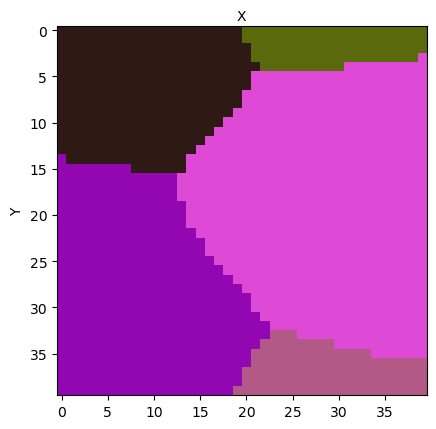

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [59]:
micro_crop = micro.crop(x_start=30, x_end=70, y_start=30, y_end=70, z_start=30, z_end=70, crop_name='test_crop',
                       autodelete=True)
micro_crop.print_dataset_content(short=True)
micro_crop.view_slice()

You can observe that the data that was not in the `CellData` group nor in the class data model in the original file has not been added to the cropped Microstructure (the `AmitexResults` Group for instance).

         
<div class="alert alert-warning">

**Warning** 
    
Cropping a microstructure can be long if the original microstructure is heavy and has a lot a fields for the `CellData` group. If you only want to crop some of these fields, you may want to create a new microstructure, add to its `CellData` group only the fields you want to crop, and then create your crop from this new instance.

</div>

### Creating and filling an Empty Microstructure

We will now see how to create from scratch a complete Microstructure dataset. As an exercise for this tutorial, we will attempt to recreate the cropped microstructure that has been created in the cell just above.

For that, we first need to create an empty *Microstructure* object. The *Microstructure* class can be used as the *SampleData* class constructor ([see here](./1_Getting_Information_from_SampleData_datasets.ipynb)):

In [86]:
micro2 = Microstructure(filename='Crop_remake.h5', overwrite_hdf5=True, autodelete=True)
print(micro2)

new phase added: unknown
Microstructure
* name: micro
* lattice: Lattice (Symmetry.cubic) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=90.0

Dataset Content Index :
------------------------:
index printed with max depth `3` and under local root `/`

	 Name : Image_data                                H5_Path : /CellData 	
	 Name : Mesh_data                                 H5_Path : /MeshData 	
	 Name : Grain_data                                H5_Path : /GrainData 	
	 Name : Phase_data                                H5_Path : /PhaseData 	
	 Name : grain_map                                 H5_Path : /CellData/grain_map 	
	 Name : Image_data_Field_index                    H5_Path : /CellData/Field_index 	
	 Name : phase_map                                 H5_Path : /CellData/phase_map 	
	 Name : mask                                      H5_Path : /CellData/mask 	
	 Name : GrainDataTable                            H5_Path : /GrainData/GrainDataTable 	
	 Name : phase_01           

In [93]:
print(micro2.GrainDataTable)

[]


The new microstructure has been created, with the complete class data model filled with empty data items. We will now fill it with data corresponding to the cropped region in the previous subsection.

### Setting CellData items

As an *Image Group*, you can add fields to the `CellData` with the *SampleData* method `add_field`. In the specific case of the `Microstructure` class, you can use specific methods to set the value of the fields that are part of the class data model: `set_mask` , `set_grain_map` and `set_phase_map`.

We are trying to recreate a cropped microstructure with a uniform mask and no phase map. We need to create the appropriate grain map and mask arrays to set their value in the dataset:

In [88]:
# Crop manually the original grain map
grain_map_original = micro.get_grain_map()
grain_map_crop = grain_map_original[30:70,30:70,30:70]

# Create a mask array full of ones with appropriate shape
mask_crop = np.ones_like(grain_map_crop)

Now that we have created our arrays, we can set the `CellData` fields. **Note that when you add the first CellData field, you have to specify a pixel/voxel size to set the scale of the image**. 



using slice value 20


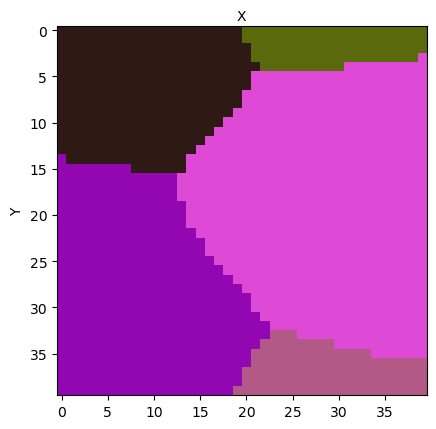

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:xlabel='X', ylabel='Y'>)

In [89]:
# retrieve voxel size of original microstructure
voxel_size = micro.get_voxel_size()

# set the grain map of our new microstructure
micro2.set_grain_map(grain_map_crop, voxel_size)

# set the mask
micro2.set_mask(mask_crop)

# visualize slice of added arrays
micro2.view_slice()

To add the other fields that were part of the original microstructure Image Group, we have to go back to *SampleData* methods:

In [91]:
uncertainty_map_crop = micro['uncertainty_map'][30:70,30:70,30:70]
micro2.add_field(gridname='CellData', fieldname='uncertainty_map', array=uncertainty_map_crop)

uncertainty_map_crop = micro['grain_map_raw'][30:70,30:70,30:70]
micro2.add_field(gridname='CellData', fieldname='grain_map_raw', array=uncertainty_map_crop)

micro2.print_group_content('CellData', short=True)


     --NODE Field_index: /CellData/Field_index (string_array - empty) (   63.999 Kb)
     --NODE grain_map: /CellData/grain_map (field_array) (  125.000 Kb)
     --NODE grain_map_raw: /CellData/grain_map_raw (field_array) (  125.000 Kb)
     --NODE mask: /CellData/mask (field_array) (  125.000 Kb)
     --NODE phase_map: /CellData/phase_map (field_array - empty) (   64.000 Kb)
     --NODE uncertainty_map: /CellData/uncertainty_map (field_array) (   62.500 Kb)



### Setting the phase

Likewise, we can take advantage of the `get_phase` and `set_phase` methods to transfer the phase data from the original dataset to our new one. The `set_phase` method takes as argument a *pymicro* *CrystallinePhase* object. These object contain an identification number for the phase. If a phase with same number already exists in the dataset, it is overwritten by the inputted one.

Let us add phase data to our dataset:

In [92]:
phase = micro.get_phase(1)
print(phase)

micro2.set_phase(phase)
print(micro2.get_phase_ids_list())
print(micro2.get_phase(1))

Phase 1 (Ti grade 2) 
	-- Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0
	-- elastic constants: [162000.0, 92000.0, 69000.0, 180000.0, 46700.0]
setting phase 1 with Ti grade 2
[1]
Phase 1 (Ti grade 2) 
	-- Lattice (Symmetry.hexagonal) a=1.000, b=1.000, c=1.000 alpha=90.0, beta=90.0, gamma=120.0
	-- elastic constants: [162000.0, 92000.0, 69000.0, 180000.0, 46700.0]


Note that phases can also be added with the `set_phases` method, that takes as input a list of *pymicro* *CrystallinePhase* objects. You can also use the `add_phase` method, that adds a *CrystallinePhase* object to the dataset with the next available phase identification number of the microstructure.

### Setting the GrainDataTable

The *Microstructure* class offers several ways to fill the GrainDataTable, that are successively reviewed in this subsection.

#### From the grain map

As detailed earlier, the *GrainDataTable* contains data describing the grains position and morphology. These values can be computed from the grain map, that provides the full geometry of each grain. Specific methods of the `Microstucture` class allow to compute those values and automatically fill the *GrainDataTable* with them. They are:

* `recompute_grain_centers`: computes and fills the `center` column of the *GrainDataTable* from the grains geometry in grain map
* `recompute_grain_volumes`: computes and fills the `volume` column of the *GrainDataTable* from the grains geometry in grain map
* `recompute_grain_bounding_boxes`: computes and fills the `bounding_box` column of the *GrainDataTable* from the grains geometry in grain map

If you need to call them all, you can do it at once with the `build_grain_table_from_grain_map`, that will first synchronize the grain ids that are in the *grain map* and the *GrainDataTable*, and then call the 3 previous methods to fill the geometric grain data in the table. We will use for our tutorial exercise:

In [94]:
micro2.build_grain_table_from_grain_map()
print(micro2.GrainDataTable)

adding 9 grains to the microstructure
[([[ 0, 13], [20, 40], [33, 40]], [-0.01886625,  0.01578343,  0.0216327 ],   34, [ 1.8039021e+01, -4.6116508e+01,  2.4090748e+01], 1.3164898e-06)
 ([[ 0, 40], [ 0, 24], [22, 40]], [-0.00033868, -0.0152649 ,  0.01731798],  107, [ 2.7277954e+00,  3.8666222e+00,  3.0442362e+00], 1.1594189e-05)
 ([[ 0, 24], [10, 40], [ 0, 39]], [-0.01444502,  0.0103255 , -0.00216276],  164, [ 6.3165874e+01, -8.7734337e+01,  4.9011006e+00], 2.4938856e-05)
 ([[ 0, 23], [ 0, 17], [ 0, 40]], [-0.01349942, -0.01565468, -0.00471803],  196, [-6.0964459e-01, -1.4468047e-01, -2.3179213e-02], 1.5941330e-05)
 ([[ 9, 40], [26, 40], [ 0, 27]], [ 0.00772108,  0.01941636, -0.01246925],  223, [-1.1969326e+01, -8.6379910e+00, -7.3886573e-01], 8.1331827e-06)
 ([[11, 40], [ 3, 36], [ 0, 34]], [ 0.01088636, -0.00186796, -0.00645274],  485, [ 6.6325707e+00, -1.2901696e+00,  1.0559826e+01], 3.3618609e-05)
 ([[ 8, 40], [10, 40], [23, 40]], [ 0.00810409,  0.00917885,  0.01690876],  692, [ 1.4

The table has been updated with the geometric data of 9 grains, the grain identity number. **You can also see that the method has added a random orientation to each grain.** If you want to avoid this, you may use instead the `compute_grains_geometry` method, that do not generates random orientations for the grains but fills orientation with zeros.

#### From data arrays

So, at this point, our *GrainDataTable* has its geometric values in accordance with the grain map, but wrong grain orientations, that have been randomly generated. We can however get the correct grain orientations from the original example microstructure dataset, with the `get_grain_rodrigues` method: 

In [103]:
# get the list of grain ids of the new microstructure
new_ids = micro2.get_grain_ids().tolist()

# get the orientations of this list of grains
orientations = micro.get_grain_rodrigues(new_ids)

In [100]:
print(orientations)

[[ 0.6985433  -0.30674216  0.23611188]
 [ 0.51318526  0.6922173   0.09951874]
 [ 0.21065354 -0.9373515   0.23172894]
 [-0.28858265  0.75905836  0.1430808 ]
 [ 0.82040954  0.45255002 -0.02743571]
 [-0.04288794 -0.9335458   0.0118214 ]
 [-0.5966228   0.620786   -0.18180412]
 [ 0.57177645 -0.53374106 -0.03578908]
 [-0.778519   -0.5381718   0.19439915]]


Now, we can use the `set_orientations` method to add this information to our data table:

In [119]:
micro2.set_orientations(orientations)

print(micro2.GrainDataTable['orientation'])

[[ 0.6985433  -0.30674216  0.23611188]
 [ 0.51318526  0.6922173   0.09951874]
 [ 0.21065354 -0.9373515   0.23172894]
 [-0.28858265  0.75905836  0.1430808 ]
 [ 0.82040954  0.45255002 -0.02743571]
 [-0.04288794 -0.9335458   0.0118214 ]
 [-0.5966228   0.620786   -0.18180412]
 [ 0.57177645 -0.53374106 -0.03578908]
 [-0.778519   -0.5381718   0.19439915]]


Similar methods exist for the rest of the data in the table: 

* `set_centers`
* `set_bounding_boxes`
* `set_volumes`

#### Getting/Setting data for/from a specific grain

To get information from a specific grain, you use the *GrainDataTable* as a standard *Numpy* structured array:

In [112]:
grain_index = np.where(micro2.GrainDataTable['idnumber'] == 485)
print(f'Grain 485 center is {micro2.GrainDataTable[grain_index]["center"]}')
print(f'Grain 485 volume is {micro2.GrainDataTable[grain_index]["volume"]}')

Grain 485 center is [[ 0.01088636 -0.00186796 -0.00645274]]
Grain 485 volume is [3.361861e-05]


But you can also iterate the `grains` attribute of the class. By doing this, you will get at each iteration a *Pytables Row* object representing a row of data in the table, *i.e.* a grain. You can access its values exactly as if it was a Numpy structured array: 

In [114]:
for g in micro2.grains:
    if g['idnumber'] == 485:
        print(f'Grain 485 center is {g["center"]}')
        print(f'Grain 485 volume is {g["volume"]}')

Grain 485 center is [ 0.01088636 -0.00186796 -0.00645274]
Grain 485 volume is 3.361860945005901e-05


You can also use this process to set specifically some values for one grain. You can iterate the table to find your grain object, set one of its values as if it was a *Numpy* structured array. Then you have to use the specific `update` method of the *Pytables Row* class to set the value in the dataset, as follows:

In [123]:
# get old orientation value 
grain_orientation = micro2.GrainDataTable[grain_index]['orientation']
print(f'The orientation of the grain is {micro2.GrainDataTable[grain_index]["orientation"]}')

# iterate to find the grain and set its orientation to a random value 
for g in micro2.grains:
    if g['idnumber'] == 485:
        g['orientation'] = np.random.rand(3)
        g.update()
print(f'The new orientation of the grain is {micro2.GrainDataTable[grain_index]["orientation"]}')

# Set back the original value of the orientation 
for g in micro2.grains:
    if g['idnumber'] == 485:
        g['orientation'] = grain_orientation
        g.update()

print(f'The orientation of the grain is back at {micro2.GrainDataTable[grain_index]["orientation"]}')

The orientation of the grain is [[-0.04288794 -0.9335458   0.0118214 ]]
The new orientation of the grain is [[0.70137733 0.6636393  0.7108861 ]]
The orientation of the grain is back at [[-0.04288794 -0.9335458   0.0118214 ]]


Obviously, you can use the same method to get/set other columns of the table (centers, bounding boxes...)

****

**We have now completed this introduction to the Microstructure class. More advanced features of the class are already implemented in the code, and many more will be in the next years. Specific tutorial Notebooks about this features will be released in the future, as well as examples presented in the documentation Cookbook.** 

We can now close our datasets, and remove the original unarchived file:

In [125]:
# remove SampleData instance
del micro2
del micro

In [126]:
os.remove(dataset_file+'.h5')
os.remove(dataset_file+'.xdmf')